   Unnamed: 0 pitch_type   game_date  release_speed  release_pos_x  \
0        2926         FF  2021-10-03           92.3           1.40   
1        3048         SL  2021-10-03           80.6           1.60   
2        3294         CU  2021-10-03           75.5           1.46   
3        3447         CU  2021-10-03           75.0           1.53   
4        3545         FF  2021-10-03           91.2           1.49   

   release_pos_z  player_name  batter  pitcher     events  ... fld_score  \
0           6.80  Smith, Will  596019   519293  field_out  ...         5   
1           6.64  Smith, Will  596019   519293        NaN  ...         5   
2           6.88  Smith, Will  596019   519293        NaN  ...         5   
3           6.83  Smith, Will  596019   519293        NaN  ...         5   
4           6.66  Smith, Will  607043   519293  field_out  ...         5   

   post_away_score  post_home_score  post_bat_score  post_fld_score  \
0                0                5               0

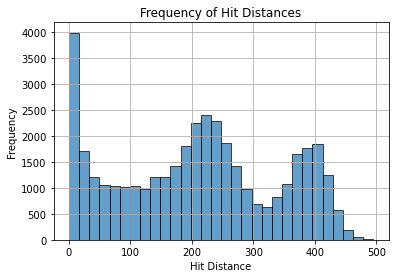

Skewness of hit_distance: 0.0211132421098541
208.37072947865374
176
hc_x                  45
hc_y                  45
release_spin_rate    122
release_extension    122
spin_axis            122
dtype: int64


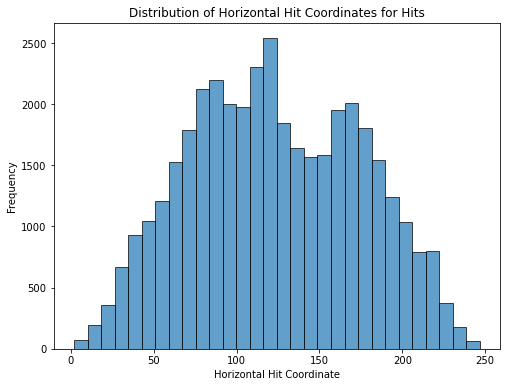

Skewness of hc_x: 0.05990286275768923
120.06
131
release_spin_rate    122
release_extension    122
spin_axis            122
dtype: int64


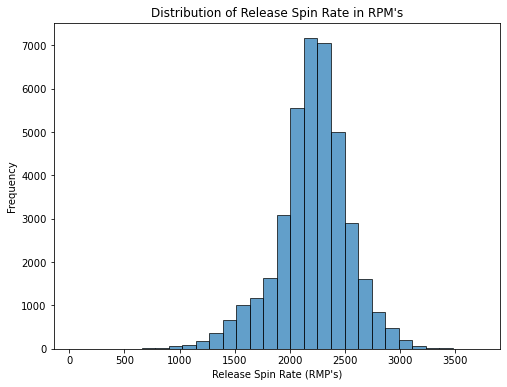

Skewness of release spin rate: -0.5424602662397109
2227.0


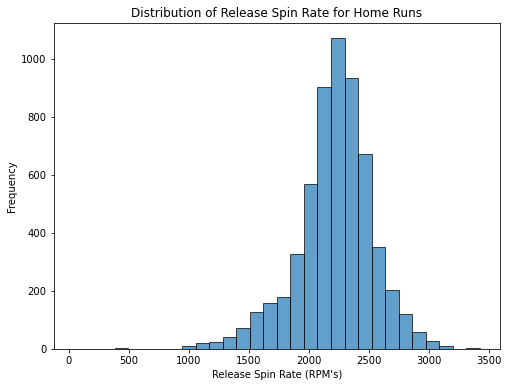

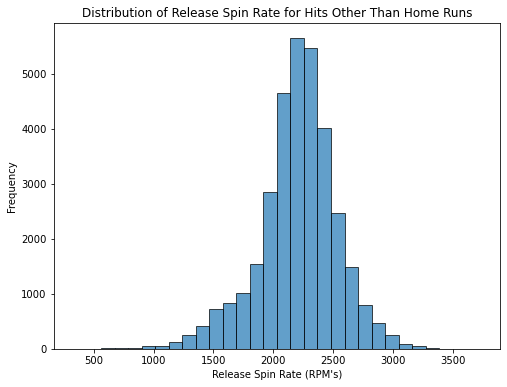

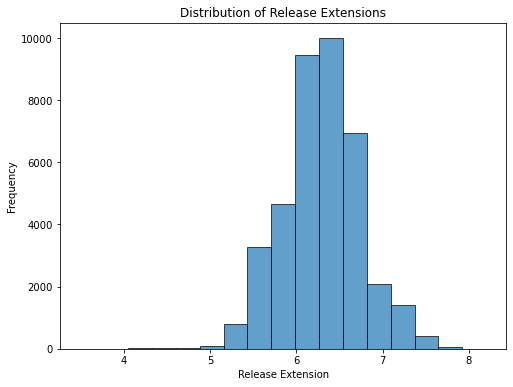

Skewness of release extension: 0.03777798299166975
6.3


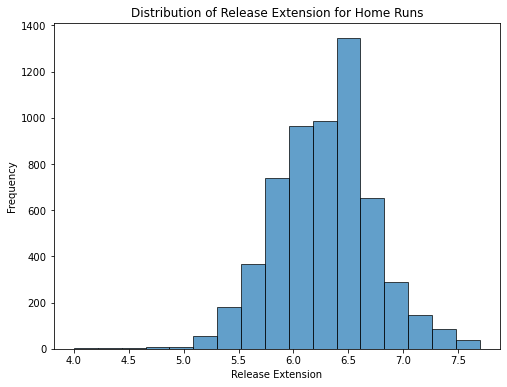

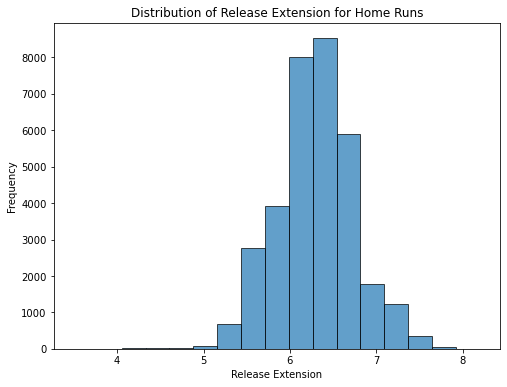

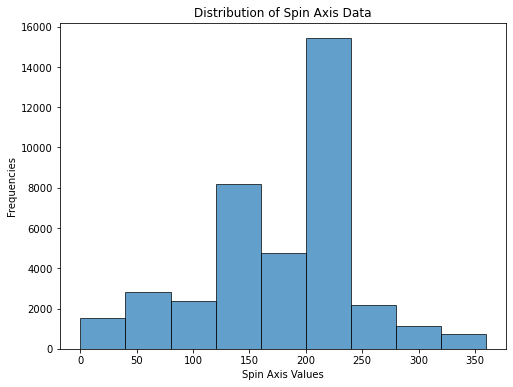

Skewness of spin axis: -0.40872163972126857
199.0


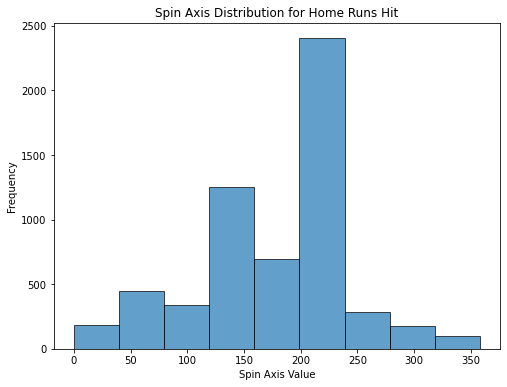

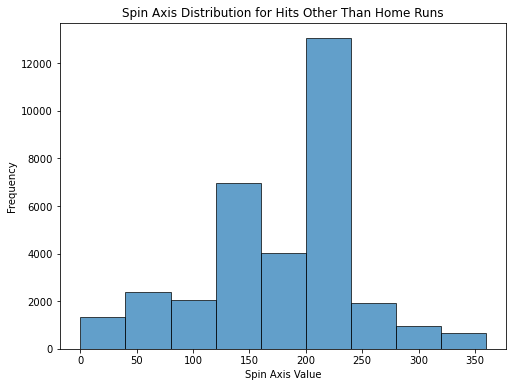

0
Series([], dtype: int64)
Index(['release_speed', 'release_pos_x', 'release_pos_z', 'zone', 'balls',
       'strikes', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'hc_x', 'hc_y',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'hit_distance_sc',
       'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'estimated_ba_using_speedangle',
       'estimated_woba_using_speedangle', 'woba_value', 'woba_denom',
       'babip_value', 'iso_value', 'launch_speed_angle', 'pitch_number',
       'spin_axis', 'delta_home_win_exp', 'delta_run_exp', 'label',
       'pitch_type_numeric', 'bb_type_numeric', 'stand_numeric',
       'p_throws_numeric'],
      dtype='object')
5896
33457
[-2.48396158e-02  7.98858081e-03  5.69510514e-02  2.33684960e-02
  4.68747277e-02  3.99460080e-02  7.51340218e-03  7.98395569e-02
  3.97485174e-03  5.28018256e-02 -1.52281576e-01  1.58194862e-01
  1.56408630e-02  2.24118034e-02 -6.92823787e-03  3.12571482e-04
 -9.4

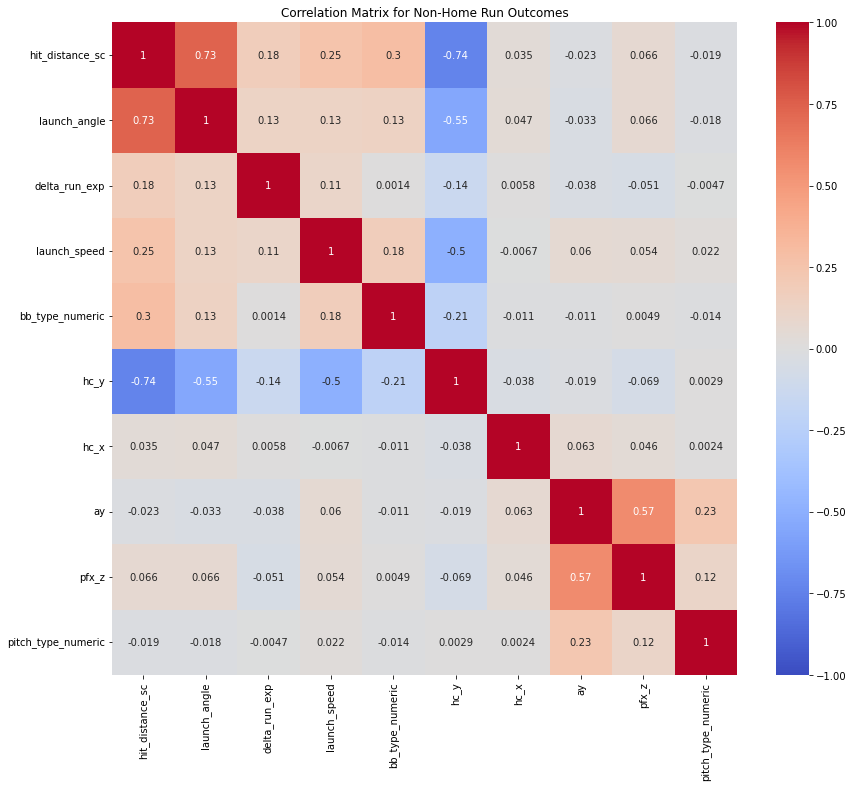

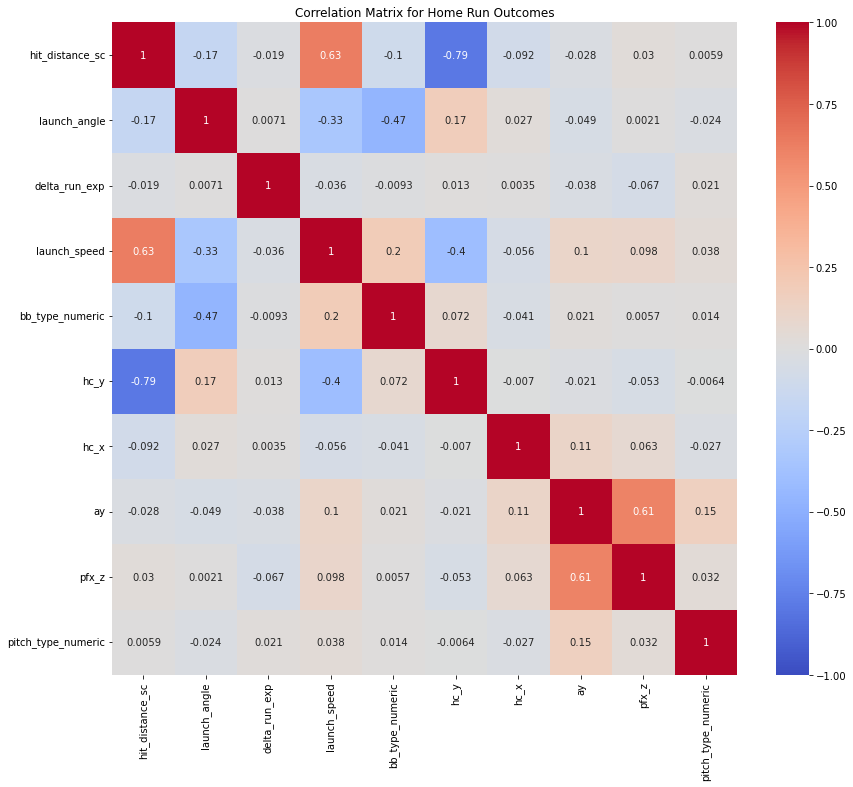

In [2]:
# Goal of this project is to use multiple machine learning methods in order to predict batted ball outcomes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

data = pd.read_csv("data_science_using_python/CS 677 Final Project Materials/archive (3)/Statcast_2021.csv")
print(data.head())

# Finding number of rows
num_rows = len(data)
print(num_rows)

data["label"] = data["events"].apply(lambda x: 1 if x == "home_run" else 0) # Adding label to dataframe (1 = home run,
# 0 = non-home run)

# Preprocessing:
print(data.columns)
print(data["Unnamed: 0"].head())

hit_data = data[data["events"].isin(["single", "double", "home_run", "triple"])] # Creating new dataframe
# only containing data for hits

event_description = hit_data.groupby("events")["description"].unique() # Checking to make sure the description associated
# with each event reads "hit_in_play" only (we are only examining hits for this analysis)
print(event_description)

# Making sure game_type = R, F, D, L or W (regular season and postseason data only, no exhibition or pre-season data)
hit_data = hit_data[hit_data["game_type"].isin(["R", "F", "D", "L", "W"])]

# Joining CS (slow curve), KC (knuckle curve), and CU (curveball) to track these all under signular label of CU (curveball)
Curveball = ["CS", "KC", "CU"]
hit_data["pitch_type"] = hit_data["pitch_type"].replace(Curveball, "CU")
updated_pitch_type_counts = hit_data["pitch_type"].value_counts()
print(updated_pitch_type_counts)

# Converting categorical features from categorical to numeric variables
le = LabelEncoder()
categorical_columns = ["pitch_type", "bb_type", "stand", "p_throws"]
for column in categorical_columns:
    hit_data[column + '_numeric'] = le.fit_transform(hit_data[column])
    mapping = dict(zip(le.classes_, range(len(le.classes_))))
    print(f"Mapping for {column}: {mapping}") # Determining which numbers each pitch got mapped to for future reference

# After conversion, CH now = 0, CU = 1, EP = 2, FA = 3, FC = 4, FF = 5, FS = 6, KN = 7, SI = 8 and SL = 9.

# Now that we've narrowed down our data to just hits in play that resulted in singles, doubles, home runs, or triples,
# we can start to remove any rows that we won't need for our analysis such as team names and player names

features_to_remove = ["Unnamed: 0", "game_date", "player_name", "batter", "pitcher", "spin_dir", "spin_rate_deprecated", "break_angle_deprecated",
                    "break_length_deprecated", "home_team", "away_team", "game_year", "on_3b", "on_2b",
                    "on_1b", "outs_when_up", "tfs_deprecated", "tfs_zulu_deprecated", "fielder_2", "umpire", 
                     "sv_id", "pitcher.1", "fielder_2.1", "fielder_3", "fielder_4", "fielder_5", "fielder_6", 
                     "fielder_7", "fielder_8", "fielder_9", "at_bat_number", "bat_score", "fld_score", "if_fielding_alignment",
                    "of_fielding_alignment", "des", "description", "game_type", "type", "sz_top", "sz_bot", "game_pk",
                    "hit_location", "pitch_type", "inning", "inning_topbot", "pitch_name", "home_score", "away_score",
                    "post_away_score", "post_home_score", "post_bat_score", "post_fld_score", "events", "pitch_type",
                    "bb_type", "stand", "p_throws"]

hit_data.drop(columns = features_to_remove, inplace = True)
hit_data.reset_index(drop = True, inplace = True)
print(hit_data.head())

# Checking the dataset for the presence of any NA values
na_values = hit_data.isna().sum()
print(na_values[na_values > 0])

# Checking each row to figure out the number of rows which contain data with NaN in them
rows_with_na = hit_data.isna().any(axis = 1)
print(rows_with_na.sum()) # There are 262 row with NA values in them.

# Visually examining the hit distance column using a historgram displaying the distribution of the hit distance data
hit_data["hit_distance_sc"].hist(bins = 30, edgecolor = "k", alpha = 0.7)
plt.title("Frequency of Hit Distances")
plt.xlabel("Hit Distance")
plt.ylabel("Frequency")
plt.show() # Data appears to be heavily right skewed

# Determining whether data is right or left skewed using .skew()
skewness = hit_data["hit_distance_sc"].skew()
print(f"Skewness of hit_distance: {skewness}") # Hit distance is close to symmetric according to skew

# Finding mean hit distance because might be a good idea to use mean hit distance to replace NaN values
mean_hit_distance = hit_data["hit_distance_sc"].mean()
print(mean_hit_distance) # Would not make sense to use mean hit distance in place of NaN value because this could
# lead to increased misclassifications (median distance was 154.53). Therefore, instead of replacing the NA values 
# in the hit distance column with the median hit distance or mean hit distance (doesn't make sense either because 
# column = skewed right), we will simply remove rows with NaN in them for hit distance.

# Removing rows with NA's for hit distance (cannot use mean distance here because some events labeled as home runs
# would not travel far enough to be classified as home runs)
hit_data = hit_data.dropna(subset = ["hit_distance_sc"])
hit_data.reset_index(drop = True, inplace = True)

# Removing rows with an NA for pitch type (label cannot be assigned if we don't know what was thrown, numeric label
# for each pitch)
hit_data = hit_data.dropna(subset = ["pitch_type_numeric"])
hit_data.reset_index(drop = True, inplace = True)

# Removing rows with NA's for zone (cannot be assigned artifically if we don't know which part of the zone the pitch crossed the plate,
# again, this is a numeric label)
hit_data = hit_data.dropna(subset = ["zone"])
hit_data.reset_index(drop = True, inplace = True)

# Checking how many NA's remain after making the previous changes
rows_with_na = hit_data.isna().any(axis = 1)
print(rows_with_na.sum()) # There are 176 rows remaining with NA's
na_values = hit_data.isna().sum()
print(na_values[na_values > 0]) # There are primarily 5 columns leading to NA's, which are hit coordinate x, hit coordinate y,
# release_spin_rate, release_extension, and spin_axis

# Visually examining the hc_x column using a histogram
plt.figure(figsize = (8, 6))
plt.hist(hit_data["hc_x"], bins = 30, edgecolor = "black", alpha = 0.7)
plt.title("Distribution of Horizontal Hit Coordinates for Hits")
plt.xlabel("Horizontal Hit Coordinate")
plt.ylabel("Frequency")
plt.show()

skewness = hit_data["hc_x"].skew()
print(f"Skewness of hc_x: {skewness}") # Data has very small skew to right

median_hc_x = hit_data["hc_x"].median()
print(median_hc_x)# Could use mean or median value to replace NA values for hc_x, but since we are not doing this to
# replace hc_y values and instead are just removing these NA values, we will remain consistent and do that for
# hc_x because these coordinates are often reported together

# To keep strategy consistent across both hit coordinates, we will not use the mean to or median value of hc_x to 
# replace NA and will instead remove any NA values for hc_x
hit_data = hit_data.dropna(subset = ["hc_x"])
hit_data.reset_index(drop = True, inplace = True)

# Removing rows with NA's for hit coordinate y (cannot be assigned artificially if we don't know the vertical plane on
# which a batted ball crossed the plate because it could lead to misclassification of a hit)
hit_data = hit_data.dropna(subset = ["hc_y"])
hit_data.reset_index(drop = True, inplace = True)

# Checking how many NA's remain after making the previous changes
rows_with_na = hit_data.isna().any(axis = 1)
print(rows_with_na.sum()) # There are 131 rows remaining with NA's
na_values = hit_data.isna().sum()
print(na_values[na_values > 0]) # Columns with NA's = Release spin rate, release extension, and spin axis

# Examining the distribution of the release spin rate data using histogram
plt.figure(figsize = (8, 6))
plt.hist(hit_data["release_spin_rate"], bins = 30, edgecolor = "black", alpha = 0.7)
plt.title("Distribution of Release Spin Rate in RPM's")
plt.xlabel("Release Spin Rate (RMP's)")
plt.ylabel("Frequency")
plt.show()

skewness = hit_data["release_spin_rate"].skew()
print(f"Skewness of release spin rate: {skewness}")

median_release_spin_rate = hit_data["release_spin_rate"].median()
print(median_release_spin_rate)

home_runs = hit_data[hit_data["label"] == 1]
non_home_runs = hit_data[hit_data["label"] == 0]
release_spin_rate_home_runs = home_runs["release_spin_rate"]
release_spin_rate_non_home_runs = non_home_runs["release_spin_rate"]

plt.figure(figsize=(8, 6))
plt.hist(release_spin_rate_home_runs, bins = 30, edgecolor = "black", alpha = 0.7)
plt.title("Distribution of Release Spin Rate for Home Runs")
plt.xlabel("Release Spin Rate (RPM's)")
plt.ylabel("Frequency")
plt.show() # Makes sense to use median to replace NA values for this column as this value generalizes well to 
# entire dataset and home runs

plt.figure(figsize=(8, 6))
plt.hist(release_spin_rate_non_home_runs, bins = 30, edgecolor = "black", alpha = 0.7)
plt.title("Distribution of Release Spin Rate for Hits Other Than Home Runs")
plt.xlabel("Release Spin Rate (RPM's)")
plt.ylabel("Frequency")
plt.show() # Also is a value that generalizes well for hits other than home runs


# Filling NA values for Release Spin Rate with median value (2227.0)
hit_data["release_spin_rate"] = hit_data["release_spin_rate"].fillna(median_release_spin_rate)

# Examining the distribution of the release extension data using a histogram
plt.figure(figsize = (8, 6))
plt.hist(hit_data["release_extension"], bins = len("release_extension"), edgecolor = "black", alpha = 0.7)
plt.title("Distribution of Release Extensions")
plt.xlabel("Release Extension")
plt.ylabel("Frequency")
plt.show()

skewness = hit_data["release_extension"].skew()
print(f"Skewness of release extension: {skewness}")

median_release_extension = hit_data["release_extension"].median()
print(median_release_extension)

release_extension_home_runs = home_runs["release_extension"]
release_extension_non_home_runs = non_home_runs["release_extension"]

plt.figure(figsize=(8, 6))
plt.hist(release_extension_home_runs, bins = len("release_extension"), edgecolor = "black", alpha = 0.7)
plt.title("Distribution of Release Extension for Home Runs")
plt.xlabel("Release Extension")
plt.ylabel("Frequency")
plt.show() # Makes sense to use median to replace NA values for this column as this generalizes well to home runs

plt.figure(figsize=(8, 6))
plt.hist(release_extension_non_home_runs, bins = len("release_extension"), edgecolor = "black", alpha = 0.7)
plt.title("Distribution of Release Extension for Home Runs")
plt.xlabel("Release Extension")
plt.ylabel("Frequency")
plt.show() # Also generalizes well for non-home run outcomes

# Filling NA values for Release Extension with median value (6.30)
hit_data["release_extension"] = hit_data["release_extension"].fillna(median_release_extension)

# Examining the distribution of the spin axis data using a histogram
plt.figure(figsize = (8, 6))
plt.hist(hit_data["spin_axis"], bins = len("spin_axis"), edgecolor = "black", alpha = 0.7)
plt.title("Distribution of Spin Axis Data")
plt.xlabel("Spin Axis Values")
plt.ylabel("Frequencies")
plt.show()

skewness = hit_data["spin_axis"].skew()
print(f"Skewness of spin axis: {skewness}") # Data is left skewed since skewness value = negative

median_spin_axis = hit_data["spin_axis"].median()
print(median_spin_axis) # Value = 199.0

# Examining how well this median value generalizes to the dataset
spin_axis_home_runs = home_runs["spin_axis"]
spin_axis_non_home_runs = non_home_runs["spin_axis"]

plt.figure(figsize=(8, 6))
plt.hist(spin_axis_home_runs, bins = len("spin_axis"), edgecolor = "black", alpha = 0.7)
plt.title("Spin Axis Distribution for Home Runs Hit")
plt.xlabel("Spin Axis Value")
plt.ylabel("Frequency")
plt.show() # Generalizes well to data for home runs

plt.figure(figsize=(8, 6))
plt.hist(spin_axis_non_home_runs, bins = len("spin_axis"), edgecolor = "black", alpha = 0.7)
plt.title("Spin Axis Distribution for Hits Other Than Home Runs")
plt.xlabel("Spin Axis Value")
plt.ylabel("Frequency")
plt.show() # Also generalizes well to data for non-home runs

# Filling NA values for Release Extension with median value (199.0)
hit_data["spin_axis"] = hit_data["spin_axis"].fillna(median_spin_axis)

# Examining whether there are any remaining NA values in the dataset
rows_with_na = hit_data.isna().any(axis = 1)
print(rows_with_na.sum())
na_values = hit_data.isna().sum()
print(na_values[na_values > 0]) # There are no NA values remaining or rows contianing NA values, so now we can move
# on to our logistic regression to determine which features are the 10 most important

# Setting up our logisitic regression to determine the 10 most important features:
print(hit_data.columns)

print(len(hit_data[hit_data["label"] == 1]))

print(len(hit_data[hit_data["label"] == 0]))

feature_names = ["release_speed", "release_pos_x", "release_pos_z", "zone", "balls", "strikes", "pfx_x", "pfx_z",
                "plate_x", "plate_z", "hc_x", "hc_y", "vx0", "vy0", "vz0", "ax", "ay", "az", "hit_distance_sc", 
                "launch_speed", "launch_angle", "effective_speed", "release_spin_rate", "release_extension", 
                "release_pos_y", "estimated_woba_using_speedangle", "launch_speed_angle", 
                 "pitch_number", "spin_axis", "delta_home_win_exp", "delta_run_exp", "pitch_type_numeric","bb_type_numeric", 
                 "stand_numeric", "p_throws_numeric", "woba_value", "woba_denom", "iso_value"]

X = hit_data[feature_names].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = hit_data["label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 3) # Dividing test and train
# sets 50/50

log_reg_classifier = LogisticRegression(max_iter = 150)
log_reg_classifier.fit(X_train, y_train) # Fitting our classifier on X_train and y_train
predictions = log_reg_classifier.predict(X_test) # Coming up with our predictions for X_test based on trained classifier

coefficients = log_reg_classifier.coef_[0]
print(coefficients) # Printing the coefficients for the logistic regression classifier

coeff_abs = np.abs(coefficients) # Taking the absolute value of the coefficients and then sorting these values from
# highest to lowest
sorted_idx = np.argsort(coeff_abs)[::-1]
sorted_feature_names = np.array(feature_names)[sorted_idx] # Turning feature_names into an array sorted by the 
# sorted index created earlier
print(sorted_feature_names) # Printing these values to get the feature names sorted in terms of importance

# The 10 most important features = woba_value, iso_value, hit_distance_sc, launch_angle, estimated_woba_using_speedangle,
# delta_run_exp, launch_speed, bb_type_numeric, hc_y, and hc_x. However, woba_value and iso_value are directly predictive
# of home runs because they both assign a singular value to this outcome, so these features should not be considered
# for our analysis because they have a correlation of 1. Additionally, estimated_woba_using_speedangle is derived from
# both launch_angle and launch_speed, so if we included these three features in our analysis, multicolinearity would
# almost certainly exist. Therefore, I removed estimated_woba_using_speedangle as a feature. To replace these features,
# the next three most important features were chosen, which were ay, pfx_z, and pitch_type_numeric.

# Examining the correlations between each feature for home run outcomes and non-home run outcomes
features = ["hit_distance_sc", "launch_angle", "delta_run_exp", "launch_speed", "bb_type_numeric", "hc_y", "hc_x", 
            "ay", "pfx_z", "pitch_type_numeric", "label"] # 10 best features as determined
# above including label

df = hit_data[features] # Creating a new dataframe just containing data for each of the 10 features
df_0 = df[df["label"] == 0].drop(columns = ["label"]) # Creating two seperate dataframes from this dataframe to where
# one contains each of the features when the label = 0 (non-home run outcomes) and one contains data for each of the
# features when the label = 1 (a home run was hit)
print(df_0)
df_1 = df[df["label"] == 1].drop(columns = ["label"])
print(df_1)

corr_0 = df_0.corr() # Calculating the correlations between the features for df_0
corr_1 = df_1.corr() # Calculating the correlations between the features for df_1

# Plotting the correlation matrices for df_1 (home runs) and df_0 (non-home runs)
plt.figure(figsize = (14, 12))
sns.heatmap(corr_0, annot = True, cmap = "coolwarm", vmin = -1, vmax = 1)
plt.title("Correlation Matrix for Non-Home Run Outcomes")

plt.figure(figsize=(14, 12))
sns.heatmap(corr_1, annot = True, cmap = "coolwarm", vmin = -1, vmax = 1)
plt.title("Correlation Matrix for Home Run Outcomes")

# Checking the VIF for each feature in order to determine if multicolinearity exists between these features
df_0_const = add_constant(df_0)
df_1_const = add_constant(df_1)

vif_0 = pd.DataFrame()
vif_0["feature"] = df_0_const.columns
vif_0["VIF"] = [variance_inflation_factor(df_0_const.values, i) for i in range(df_0_const.shape[1])]

vif_1 = pd.DataFrame()
vif_1["feature"] = df_1_const.columns
vif_1["VIF"] = [variance_inflation_factor(df_1_const.values, i) for i in range(df_1_const.shape[1])]

print("VIF for Non-Home Run Outcomes (df_0):")
print(vif_0)

print("\nVIF for Home Run Outcomes (df_1):")
print(vif_1)

# Previously, there were strong indicators of multicolinearity between estimated batting average using launch speed angle
# and estimated weighted on-base percentage using launch speed angle. This makes sense because the estimated on_base
# percentage using launch speed angle is derived from both launch speed and launch angle, which were already features
# I was using in this analysis. Therefore, I removed the estimated weighted on-base percentage using launch speed angle
# from the features array. After making this change, no VIF values were above 4.4 for either class, so there are no 
# longer any strong to moderate signs of multicolinearity.

df_features = ["hit_distance_sc", "launch_angle", "delta_run_exp", "launch_speed", "bb_type_numeric", "hc_y", 
               "hc_x", "ay", "pfx_z", "pitch_type_numeric"] # Defining top 10 
# features to use in my analysis

for feature in df_features: # Creating a loop that iterates over each feature in feature_names to print the mean and 
    # standard deviation for home runs, mean and standard deviation for non-home runs, and the mean and standard deviation 
    # for the entire dataset for each feature in feature_names 
    mean_for_HR = hit_data[hit_data["label"] == 1][feature].mean()
    mean_for_non_HR = hit_data[hit_data["label"] == 0][feature].mean()
    mean_for_entire_dataset = hit_data[feature].mean()
    
    std_for_class1 = hit_data[hit_data["label"] == 1][feature].std()
    std_for_class0 = hit_data[hit_data["label"] == 0][feature].std()
    std_for_entire_dataset = hit_data[feature].std()
    
    print(f"\nMean of {feature} for HR = {mean_for_HR:.2f}, Mean of {feature} for non-HR = {mean_for_non_HR:.2f}, Mean of {feature} for whole dataset = {mean_for_entire_dataset:.2f}.")
    print(f"\nStd Dev of {feature} for HR = {std_for_class1:.2f}, Std Dev of {feature} for non-HR = {std_for_class0:.2f}, Std Dev of {feature} for whole dataset = {std_for_entire_dataset:.2f}.")



    

    






VIF for Non-Home Run Outcomes (df_0):
     feature_names        VIF
0            const  53.749153
1  hit_distance_sc   3.368111
2     launch_angle   2.172440
3    delta_run_exp   1.032359
4             hc_y   2.211057
VIF for Home Run Events (df_1):
     feature_names         VIF
0            const  877.619454
1  hit_distance_sc    2.664120
2     launch_angle    1.033997
3    delta_run_exp    1.000397
4             hc_y    2.670900
The accuracy of the Logistic Regression classifier is 0.98
The confusion matrix for the Logistic Regression classifier:
 [[6608  106]
 [  70 1087]]
The TPR of the Logisitic Regression classifier = 0.94
The TNR of the Logisitic Regression classifier = 0.98
The FPR of the Logistic Regression classifier = 0.02
The PPV of the Logistic Regression classifier = 0.91
The f1_score of the Logistic Regression classifier = 0.93
The Area Under the Curve for the Logisitic Regression classifier = 0.96

TPR when dropping hit_distance_sc was 0.82
PPV when dropping hit_distan

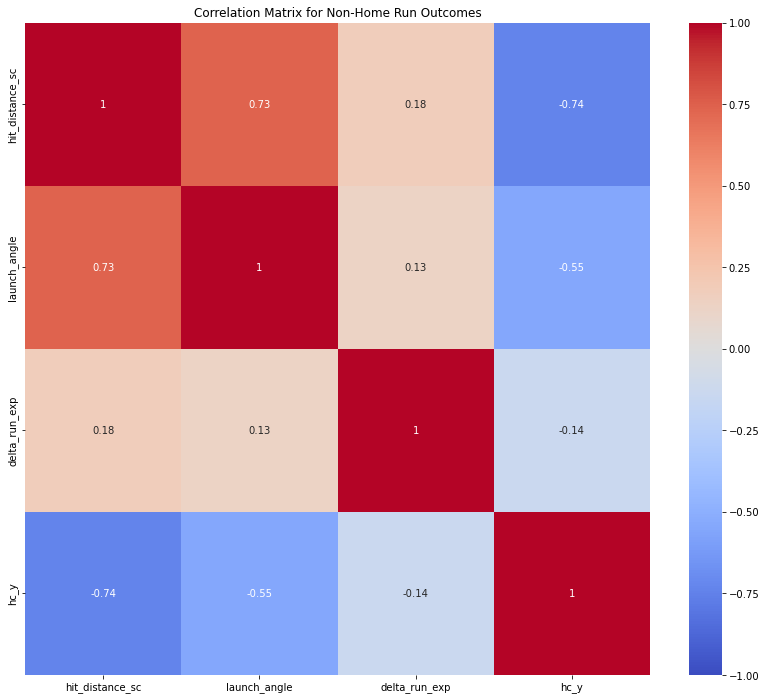

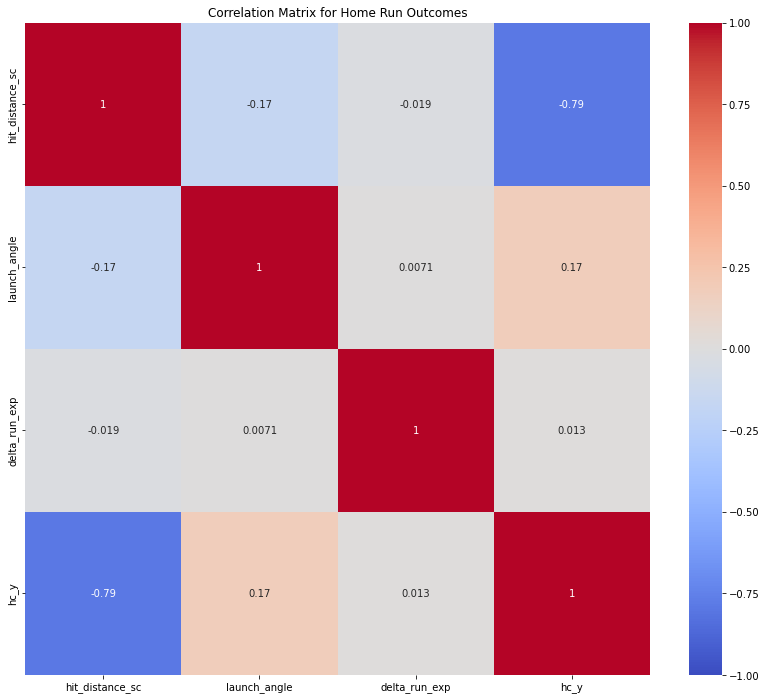

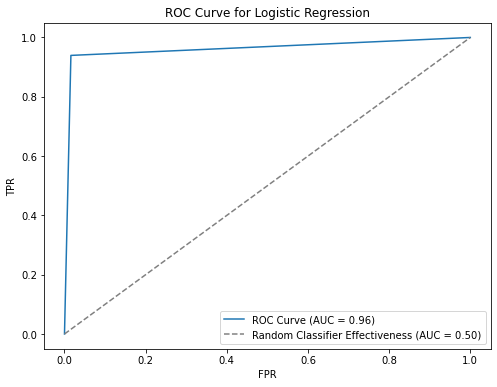

In [4]:
# First model trying to predict home runs = Logistic Regression:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score

# Examining the correlations between the 4 features we've narrowed down to using
feature_names = ["hit_distance_sc", "launch_angle", "delta_run_exp", "hc_y", "label"]

df = hit_data[feature_names] # Creating a new dataframe just containing data for the four features I'll use for this analysis
df_0 = df[df["label"] == 0].drop(columns = ["label"]) # Creating two seperate dataframes from this dataframe to where
# one contains each of the features when the label = 0 (non-home run outcomes) and one contains data for each of the
# features when the label = 1 (a home run was hit)
df_1 = df[df["label"] == 1].drop(columns = ["label"])

corr_0 = df_0.corr() # Calculating the correlations between the features for df_0
corr_1 = df_1.corr() # Calculating the correlations between the features for df_1

# Plotting the correlation matrices for df_1 (home runs) and df_0 (non-home runs)
plt.figure(figsize = (14, 12))
sns.heatmap(corr_0, annot = True, cmap = "coolwarm", vmin = -1, vmax = 1)
plt.title("Correlation Matrix for Non-Home Run Outcomes")

plt.figure(figsize=(14, 12))
sns.heatmap(corr_1, annot = True, cmap = "coolwarm", vmin = -1, vmax = 1)
plt.title("Correlation Matrix for Home Run Outcomes")

# Checking the VIF for each feature in order to determine if multicolinearity exists between these features
df_0_const = add_constant(df_0)
df_1_const = add_constant(df_1)

vif_0 = pd.DataFrame()
vif_0["feature_names"] = df_0_const.columns
vif_0["VIF"] = [variance_inflation_factor(df_0_const.values, i) for i in range(df_0_const.shape[1])]
print("VIF for Non-Home Run Outcomes (df_0):")
print(vif_0)

vif_1 = pd.DataFrame()
vif_1["feature_names"] = df_1_const.columns
vif_1["VIF"] = [variance_inflation_factor(df_1_const.values, i) for i in range(df_1_const.shape[1])]
print("VIF for Home Run Events (df_1):")
print(vif_1)

# There are some correlations that are high, but these variables are not directly related to each other in any way,
# which is indicated by the low VIF values (no features in either the home run or non-home run outcomes with values
# above 3.3)

features = ["hit_distance_sc", "launch_angle", "delta_run_exp", "hc_y"] # Features to be used for this analysis

# Implementing the logisitic regression:
X = hit_data[features].values 
y = hit_data["label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

log_reg_classifier = LogisticRegression()
log_reg_classifier.fit(X_train, y_train) # Training the logistic regression classifier on X_train and y_train
predictions = log_reg_classifier.predict(X_test) # Using the trained logistic regression classifier to predict 
# y_test based on the values in X_test

# Calculating the performance metrics for the logistic regression classifier:
accuracy = np.mean(predictions == y_test)
print(f"The accuracy of the Logistic Regression classifier is {accuracy:.2f}")
cf = confusion_matrix(y_test, predictions)
print(f"The confusion matrix for the Logistic Regression classifier:\n", cf)
tpr = recall_score(y_test, predictions, pos_label = 1)
print(f"The TPR of the Logisitic Regression classifier = {tpr:.2f}")
tnr = recall_score(y_test, predictions, pos_label = 0)
print(f"The TNR of the Logisitic Regression classifier = {tnr:.2f}")
fpr = 1 - tnr
print(f"The FPR of the Logistic Regression classifier = {fpr:.2f}")
ppv = precision_score(y_test, predictions, pos_label = 1)
print(f"The PPV of the Logistic Regression classifier = {ppv:.2f}")
f1_value = f1_score(y_test, predictions, pos_label = 1)
print(f"The f1_score of the Logistic Regression classifier = {f1_value:.2f}")
auc = roc_auc_score(y_test, predictions)
print(f"The Area Under the Curve for the Logisitic Regression classifier = {auc:.2f}")

# Plotting the ROC curve to display visually the area under the curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, label = f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], color = "gray", linestyle = "--", label = "Random Classifier Effectiveness (AUC = 0.50)")  # Line for random classifier
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve for Logistic Regression")
plt.legend(loc = "lower right")

# Logisitc Regression produces accuracy of 0.98, 6602 TN's, 1087 TP's, 112 FP's, 70 FN's, TPR = 0.94,
# FPR = 0.02, PPV = 0.91, f1 score = 0.92, and AUC = 0.96 when using the four features of hit_distance_sc, launch_angle,
# delta_run_exp, and hc_y.


# Examining whether removing certain features improves our logistic regression's metrics:
for i, feature in enumerate(features):
    X_train_truncated = np.delete(X_train, i, axis = 1)
    X_test_truncated = np.delete(X_test, i, axis = 1)
    log_reg_classifier.fit(X_train_truncated, y_train)
    predictions = log_reg_classifier.predict(X_test_truncated)
    # TPR, PPV, f1_score, and AUC are the metrics that I've chosen to evaluate the performance of my classifiers:
    tpr = recall_score(y_test, predictions, pos_label = 1)
    ppv = precision_score(y_test, predictions, pos_label = 1)
    f1_value = f1_score(y_test, predictions, pos_label = 1)
    auc = roc_auc_score(y_test, predictions)
    print(f"\nTPR when dropping {feature} was {tpr:.2f}")
    print(f"PPV when dropping {feature} was {ppv:.2f}")
    print(f"F1-score when dropping {feature} was {f1_value:.2f}") # Was weighed as most important factor since this
    # is the harmonic mean of two of the metrics that I'm using to evaluate classifier performance
    print(f"AUC when dropping {feature} was {auc:.2f}")
    
# There are several features which neither improve or negatively impact our model's performance. We will remove these features.
# These are hc_x, ay, pfx_z, and pitch_type_numeric. Also, removing launch_speed improved my model's TPR while not
# changing the model's PPV, F1-score, or AUC, so I removed this feature as well. Now the four features which are
# being used to classify home runs are hit_distance_sc, launch_angle, delta_run_exp, and hc_y.
    






The accuracy of the Decision Tree classifier is 0.98
The confusion matrix for the Decision Tree classifier:
 [[6606   82]
 [  76 1107]]
The TPR of the Decision Tree classifier = 0.94
The TNR of the Decision Tree classifier = 0.99
The FPR of the Decision Tree classifier = 0.01
The PPV of the Decision Tree classifier = 0.93
The f1_score of the Decision Tree classifier = 0.93
The Area Under the Curve for the Decision Tree classifier = 0.96
The best hyperparameters found by the grid search are: {'max_depth': 11, 'min_samples_leaf': 3, 'min_samples_split': 2}
Best F1 Score for training set found by grid search = 0.95
The f1 score of the best decision tree classifier identified using grid search = 0.94
The accuracy of the best Decision Tree classifier idenified using grid search = 0.98
The confusion matrix for the best Decision Tree classifier identified using grid search:
 [[6601   87]
 [  51 1132]]
The TPR of the best Decision Tree classifier identified using grid search = 0.96
The TNR of 

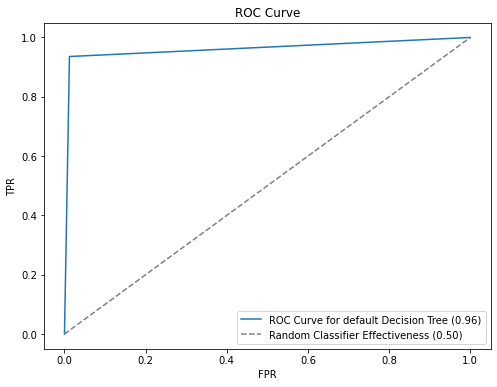

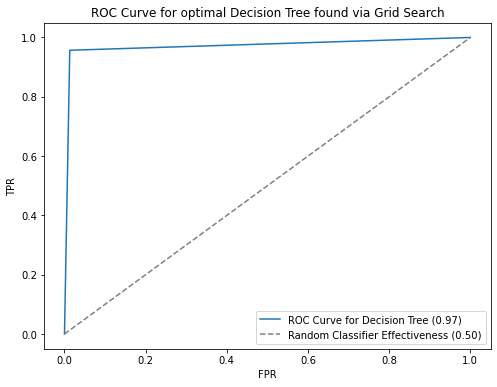

In [46]:
# Model 2 = Decision Tree (using same features as model 1 to predict home runs)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score

# Running default Decision Tree model:

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size = 0.2, random_state = 8)

clf = DTC(criterion = "entropy", random_state = 8)

clf.fit(X_train_2, y_train_2)
predictions_2 = clf.predict(X_test_2)

# Computing the performance metrics for this default classifier:

accuracy_2 = accuracy_score(y_test_2, predictions_2)
print(f"The accuracy of the Decision Tree classifier is {accuracy_2:.2f}")
cf_2 = confusion_matrix(y_test_2, predictions_2)
print(f"The confusion matrix for the Decision Tree classifier:\n", cf_2)
tpr_2 = recall_score(y_test_2, predictions_2, pos_label = 1)
print(f"The TPR of the Decision Tree classifier = {tpr_2:.2f}")
tnr_2 = recall_score(y_test_2, predictions_2, pos_label = 0)
print(f"The TNR of the Decision Tree classifier = {tnr_2:.2f}")
fpr_2 = 1 - tnr_2
print(f"The FPR of the Decision Tree classifier = {fpr_2:.2f}")
ppv_2 = precision_score(y_test_2, predictions_2, pos_label = 1)
print(f"The PPV of the Decision Tree classifier = {ppv_2:.2f}")
f1_value_2 = f1_score(y_test_2, predictions_2, pos_label = 1)
print(f"The f1_score of the Decision Tree classifier = {f1_value_2:.2f}")
auc_2 = roc_auc_score(y_test_2, predictions_2)
print(f"The Area Under the Curve for the Decision Tree classifier = {auc_2:.2f}")

# Plotting the ROC curve to display visually the area under the curve for the default Decision Tree
fpr, tpr, thresholds = roc_curve(y_test_2, predictions_2)
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, label = f"ROC Curve for default Decision Tree ({auc_2:.2f})")
plt.plot([0, 1], [0, 1], color = "gray", linestyle = "--", label = "Random Classifier Effectiveness (0.50)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve for Decision Tree using Default Hyperparameters")
plt.legend(loc = "lower right")

# When using default hyperparameters, the accuracy = 0.98, 6606 TN's, 1107 TP's, 82 FP's, 76 FN's, TPR = 0.94, 
# TNR = 0.99, PPV = 0.93, f1 score = 0.93, and the auc = 0.96

# Experiments to determine the most optimal hyperparameters for the decision tree:
param_grid = {"max_depth": np.arange(1, 13), "min_samples_split": np.arange(2, 13), "min_samples_leaf": np.arange(1, 13)}
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 5, scoring = "f1")
grid_search.fit(X_train_2, y_train_2)
best_params_grid = grid_search.best_params_
print(f"The best hyperparameters found by the grid search are: {best_params_grid}")
best_score_grid = grid_search.best_score_
print(f"Best F1 Score for training set found by grid search = {best_score_grid:.2f}")
best_model_grid = grid_search.best_estimator_
predictions_grid = best_model_grid.predict(X_test_2)

# Experiment 1 = max_depth = np.arange(1, 21), min_samples_split = np.arange(2, 21), min_samples_leaf = np.arange(1, 21)
# Best hyperparameters found the grid search were max_depth = 11, min_samples_leaf = 3, and min_samples_split = 2
# Yielded F1 Score of 0.95 on training set and 0.94 on testing set

# Experiment 2 = decreasing ranges for each hyperparameter (1 through 10 for max_depth, 2 through 10 for min_samples_split,
# and 1 through 10 for min_samples_leaf)
# Best hyperparameters = max_depth of 10, min_samples_leaf of 7, min_samples_split of 2, produced F1 Score of 0.95 on training set
# 0.94 on testing set

# Experiment 3 = testing max_depth = 1 through 8, min_samples_split = 2 through 8, min_samples_leaf = 1 through 8,
# best hyperparameters = 7, 4 and 2 with f1 score of 0.94 for both training and testing

# Experiment 4 = testing max_depth = 1 through 9, min_samples_split = 2 through 9, min_samples_leaf = 1 through 9,
# Best hyperparameters = max_depth of 8, min_samples_leaf of 3, min_samples_split of 2 with F1 values 0.95 for training and
# 0.94 for testing

# Experiment 5 = testing max_depth = 1 through 13, min_samples_split = 2 through 13, min_samples_leaf = 1 through 13,
# Best hyperparameters = max_depth of 11, min_samples_leaf of 3, min_samples_split of 2 (same as Experiment 1), same
# f1 scores for training and testing sets as Experiment 1 as well

# Experiment 6 (final experiment) = testing max_depth = 1 through 25, min_samples_split = 1 through 25, min_samples_leaf = 1 through 25,
# Best hyperparameters remain the same and so do the best F1 scores (best model = max_depth = 11, min_samples_leaf = 3, min_samples_split = 2)

# Printing classifier performance metrics after finding optimal hyperparameters using grid search:
f1_value_grid = f1_score(y_test_2, predictions_grid)
print(f"The f1 score of the best decision tree classifier identified using grid search = {f1_value_grid:.2f}")
accuracy_grid = accuracy_score(y_test_2, predictions_grid)
print(f"The accuracy of the best Decision Tree classifier idenified using grid search = {accuracy_grid:.2f}")
cf_grid = confusion_matrix(y_test_2, predictions_grid)
print(f"The confusion matrix for the best Decision Tree classifier identified using grid search:\n", cf_grid)
tpr_grid = recall_score(y_test_2, predictions_grid, pos_label = 1)
print(f"The TPR of the best Decision Tree classifier identified using grid search = {tpr_grid:.2f}")
tnr_grid = recall_score(y_test_2, predictions_grid, pos_label = 0)
print(f"The TNR of the best Decision Tree classifier identified via grid search = {tnr_grid:.2f}")
fpr_grid = 1 - tnr_grid
print(f"The FPR of the best Decision Tree classifier identified via grid search = {fpr_grid:.2f}")
ppv_grid = precision_score(y_test_2, predictions_grid, pos_label = 1)
print(f"The PPV of the best Decision Tree classifier identified via grid search = {ppv_grid:.2f}")
auc_grid = roc_auc_score(y_test_2, predictions_grid)
print(f"The Area Under the Curve for the best Decision Tree classifier identified via grid search = {auc_grid:.2f}")

# Plotting the ROC curve to display visually the area under the curve for the optimized Decision Tree classifier
fpr, tpr, thresholds = roc_curve(y_test_2, predictions_grid)
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, label = f"ROC Curve for Decision Tree ({auc_grid:.2f})")
plt.plot([0, 1], [0, 1], color = "gray", linestyle = "--", label = "Random Classifier Effectiveness (0.50)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve for Decision Tree with Optimal Hyperparameters")
plt.legend(loc = "lower right")

# When using optimal hyperparameters, the accuracy of the decision tree = 0.98, 6601 TN's, 1132 TP's, 87 FP's, 51 FN's, TPR = 0.96, 
# TNR = 0.99, PPV = 0.93, f1 score = 0.94, and the auc = 0.97









The accuracy of the default Random Forest classifier is 0.99
The confusion matrix for the default Random Forest classifier:
 [[6680   72]
 [  29 1090]]
The TPR of the default Random Forest classifier = 0.97
The TNR of the default Random Forest classifier = 0.99
The FPR of the default Random Forest classifier = 0.01
The PPV of the default Random Forest classifier = 0.94
The f1_score of the default Random Forest classifier = 0.96
The AUC for the default Random Forest classifier = 0.98
The best hyperparameters found by the grid search are: {'max_depth': 17, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 169}
Best F1 Score for training set found by grid search = 0.96
The f1 score the best decision tree classifier identified using grid search = 0.96
The accuracy of the best Decision Tree classifier idenified using grid search = 0.99
The confusion matrix for the best Decision Tree classifier identified using grid search:
 [[6676   76]
 [  22 1097]]
The TPR of the best Decisio

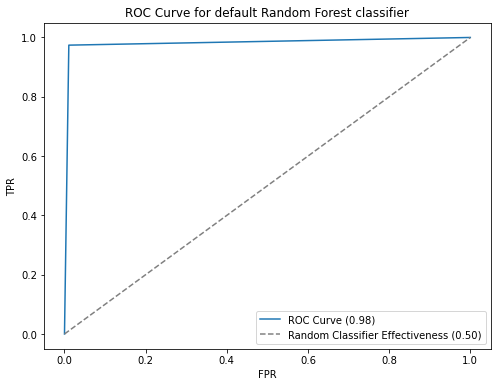

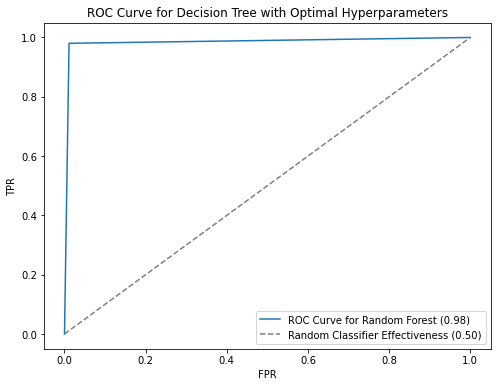

In [82]:
# Model 3 = Random Forest 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
import time

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, test_size = 0.2, random_state = 7)

model = RFC(criterion = "entropy", random_state = 7)
model.fit(X_train_3, y_train_3)
predictions_3 = model.predict(X_test_3)

accuracy_3 = accuracy_score(y_test_3, predictions_3)
print(f"The accuracy of the default Random Forest classifier is {accuracy_3:.2f}")
cf_3 = confusion_matrix(y_test_3, predictions_3)
print(f"The confusion matrix for the default Random Forest classifier:\n", cf_3)
tpr_3 = recall_score(y_test_3, predictions_3, pos_label = 1)
print(f"The TPR of the default Random Forest classifier = {tpr_3:.2f}")
tnr_3 = recall_score(y_test_3, predictions_3, pos_label = 0)
print(f"The TNR of the default Random Forest classifier = {tnr_3:.2f}")
fpr_3 = 1 - tnr_3
print(f"The FPR of the default Random Forest classifier = {fpr_3:.2f}")
ppv_3 = precision_score(y_test_3, predictions_3, pos_label = 1)
print(f"The PPV of the default Random Forest classifier = {ppv_3:.2f}")
f1_value_3 = f1_score(y_test_3, predictions_3, pos_label = 1)
print(f"The f1_score of the default Random Forest classifier = {f1_value_3:.2f}")
auc_3 = roc_auc_score(y_test_3, predictions_3)
print(f"The AUC for the default Random Forest classifier = {auc_3:.2f}")

fpr, tpr, thresholds = roc_curve(y_test_3, predictions_3)
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, label = f"ROC Curve ({auc_3:.2f})")
plt.plot([0, 1], [0, 1], color = "gray", linestyle = "--", label = "Random Classifier Effectiveness (0.50)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve for default Random Forest classifier")
plt.legend(loc = "lower right")

# When using default hyperparameters, the accuracy = 0.99, 6680 TN's, 1090 TP's, 72 FP's, 29 FN's, TPR = 0.97, 
# TNR = 0.99, PPV = 0.94, f1 score = 0.96, and the auc = 0.98

# Experiments to determine the most optimal hyperparameters for the Random Forest:
param_grid = {"max_depth": [17], "min_samples_split": [7], "min_samples_leaf": [2], 
                   "n_estimators": np.arange(168, 171)}

grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, scoring = "f1", n_jobs = -1)
grid_search.fit(X_train_3, y_train_3)
best_params_grid = grid_search.best_params_
print(f"The best hyperparameters found by the grid search are: {best_params_grid}")
best_score_grid = grid_search.best_score_
print(f"Best F1 Score for training set found by grid search = {best_score_grid:.2f}")
best_model_grid = grid_search.best_estimator_
predictions_grid = best_model_grid.predict(X_test_3)
f1_value_grid = f1_score(y_test_3, predictions_grid)
print(f"The f1 score the best decision tree classifier identified using grid search = {f1_value_grid:.2f}")

# Experiment 1: max_depth = [None, 10, 20], min_samples_split = [2, 5, 10], min_samples_leaf = [2, 5, 10], n_estimators = [50, 100, 150]
# Results: Best hyperparameters found by grid search = max_depth = 20, min_samples_split = 5, min_samples_leaf = 2, n_estimators = 150
# Best F1 Score for training = 0.96, best F1 Score for testing = 0.96

# Experiment 2: max_depth = [15, 20, 30], min_samples_split = [2, 5, 8], min_samples_leaf = [1, 2, 4], n_estimators = [100, 150, 200]
# Results: Best hyperparameters found by grid search = max_depth = 20, min_samples_leaf = 2, min_samples_split = 5, n_estimators = 150
# Best F1 Score for training = 0.96, same for testing

# Experiment 3: max_depth = [17, 20, 25], min_samples_split = 3 through 7, min_samples_leaf = [1, 2, 4], n_estimators = [125, 150, 175]
# Results: Best hyperparameters found by grid search = max_depth = 17, min_samples_leaf = 2, min_samples_split = 7, n_estimators = 175
# Best F1 Score for training = 0.96, same for testing

# Experiment 4: max_depth = [15, 17, 19], min_samples_split = [7], min_samples_leaf = [2], n_estimator = [150, 175, 185]
# Results: Best hyperparameters found by grid search = max_depth = 17, min_samples_leaf = 2, min_samples_split = 7, n_estimators = 175
# Best F1 Score for training = 0.96, same for testing

# Experiment 5: max_depth = 16 through 18, min_samples_split = [7], min_samples_leaf = [2], n_estimator = [160, 175, 180]
# Results: Best hyperparameters found by grid search = max_depth = 17, min_samples_leaf = 2, min_samples_split = 7, n_estimators = 160
# Best F1 Score for training = 0.96, same for testing

# Experiment 6: max_depth = [17], min_samples_split = [7], min_samples_leaf = [2], n_estimator = [155, 160, 170]
# Results: max_depth = 17, min_samples_split = 7, min_samples_leaf = 2, n_estimator = 170

# Experiment 7: max_depth = [17], min_samples_split = [7], min_samples_leaf = [2], n_estimator = [160, 165, 170]
# Results: max_depth = 17, min_samples_split = 7, min_samples_leaf = 2, n_estimator = 170

# Experiment 8: max_depth = 17, min_samples_split = [7], min_samples_leaf = [2], n_estimator = [165, 167, 170]
# Results: n_estimator = 170

# Experiment 9 (final experiment): max_depth = 17, min_samples_split = 7, min_samples_leaf = 2, n_estimator = np.arange(168, 171)
# Results: Optimal Random Forest parameters = max_depth = 17, min_samples_split = 7, min_samples_leaf = 2, n_estimator = 169
# F1 scores for both training and testing = 0.96


accuracy_grid = accuracy_score(y_test_3, predictions_grid)
print(f"The accuracy of the best Random Forest classifier idenified using grid search = {accuracy_grid:.2f}")
cf_grid = confusion_matrix(y_test_3, predictions_grid)
print(f"The confusion matrix for the best Random Forest classifier identified using grid search:\n", cf_grid)
tpr_grid = recall_score(y_test_3, predictions_grid, pos_label = 1)
print(f"The TPR of the best Random Forest classifier identified using grid search = {tpr_grid:.2f}")
tnr_grid = recall_score(y_test_3, predictions_grid, pos_label = 0)
print(f"The TNR of the best Random Forest classifier identified via grid search = {tnr_grid:.2f}")
fpr_grid = 1 - tnr_grid
print(f"The FPR of the best Random Forest classifier identified via grid search = {fpr_grid:.2f}")
ppv_grid = precision_score(y_test_3, predictions_grid, pos_label = 1)
print(f"The PPV of the best Random Forest classifier identified via grid search = {ppv_grid:.2f}")
auc_grid = roc_auc_score(y_test_3, predictions_grid)
print(f"The AUC for the best Random Forest classifier identified via grid search = {auc_grid:.2f}")

# Plotting the ROC curve to display visually the area under the curve for the optimized Decision Tree classifier
fpr, tpr, thresholds = roc_curve(y_test_3, predictions_grid)
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, label = f"ROC Curve ({auc_grid:.2f})")
plt.plot([0, 1], [0, 1], color = "gray", linestyle = "--", label = "Random Classifier Effectiveness (0.50)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve for Random Forest with Optimal Hyperparameters")
plt.legend(loc = "lower right")

# When using optimal hyperparameters, the accuracy of the Random Forest = 0.99, 6676 TN's, 1097 TP's, 76 FP's, 22 FN's, TPR = 0.98, 
# TNR = 0.99, PPV = 0.94, f1 score = 0.96, and the auc = 0.98.







